In [1]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

import statsmodels.api as sm
from   statsmodels.regression.rolling import RollingOLS

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\TreasuryInflationPCA\root\src")
from DataPreprocess import InflationPCA

In [73]:
df_tsy = (InflationPCA().get_tsy_fut().assign(
    security = lambda x: x.security.str.split(" ").str[0])
    [["date", "security", "PX_bps"]])

df_combined = (InflationPCA().pca_signal()[
    ["date", "input_val", "variable", "lag_spread", "spread"]].
    merge(right = df_tsy, how = "inner", on = ["date"]).
    assign(group_var = lambda x: x.security + " " + x.variable + " " + x.input_val))

In [4]:
def _get_rolling_regression(df: pd.DataFrame, window_ratio: float) -> pd.DataFrame:
    
    window = int(len(df) * window_ratio)
    
    df_out = (RollingOLS(
        endog   = df.PX_bps,
        exog    = sm.add_constant(df.lag_spread),
        window  = window).
        fit().
        params.
        assign(date = lambda x: df.date).
        rename(columns = {
            "const"     : "alpha",
            "lag_spread": "beta"}).
        merge(right = df, how = "inner", on = ["date"]).
        sort_values("date").
        assign(lag_beta = lambda x: x.beta.shift()).
        dropna())
    
    return df_out

def get_rolling_regression(df_combined: pd.DataFrame, window_ratio: float = 0.15) -> pd.DataFrame: 

    df_out = (df_combined.groupby(
        "group_var").
        apply(_get_rolling_regression, window_ratio).
        reset_index(drop = True))
    
    return df_out

df_rolling = get_rolling_regression(df_combined)

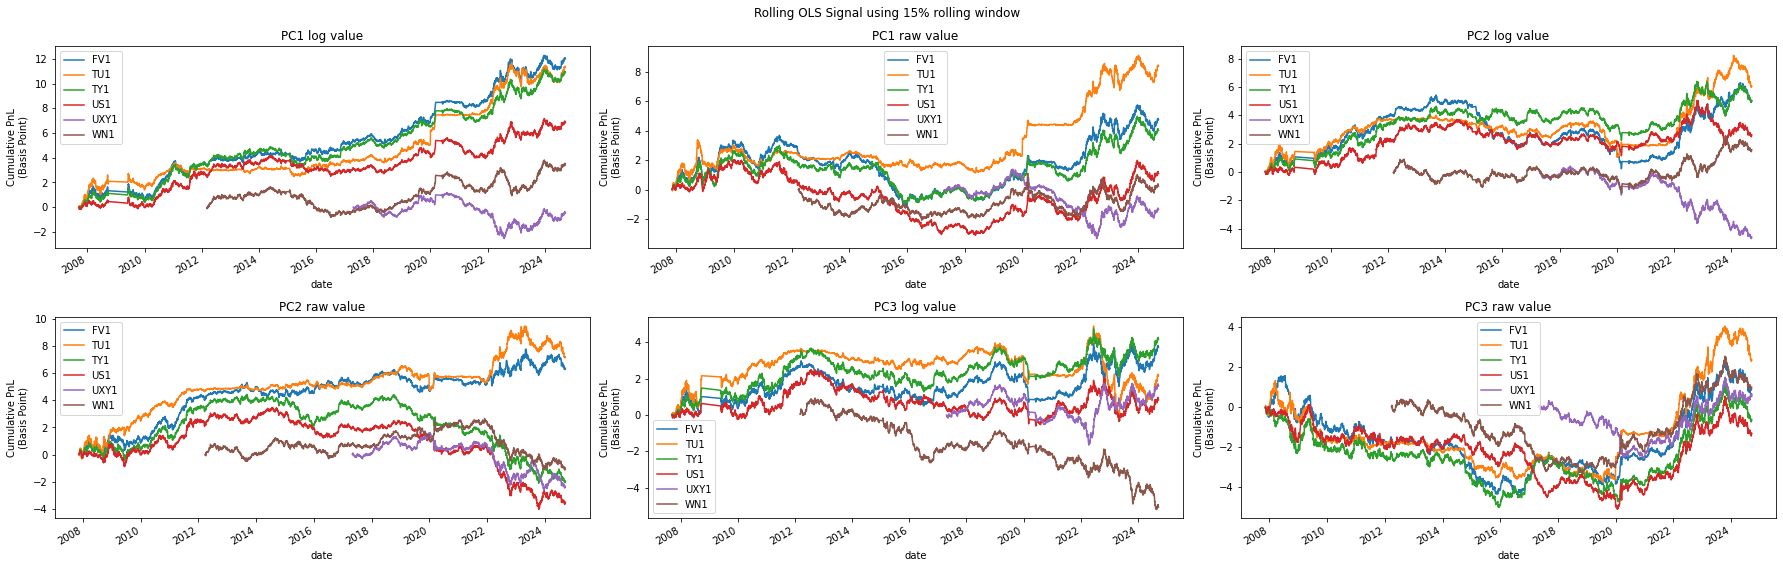

In [5]:
def plot_rolling_sharpe(df_rolling: pd.DataFrame) -> plt.Figure: 
    
    df_tmp = (df_rolling.drop(
        columns = ["group_var"]).
        assign(group_var = lambda x: x.variable + " " + x.input_val))

    group_vars = df_tmp.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 3, figsize = (25,8))

    for group_var, ax in zip(group_vars, axes.flatten()): 

        (df_tmp.query(
            "group_var == @group_var").
            assign(signal_rtn = lambda x: np.sign(x.lag_beta * x.lag_spread) * x.PX_bps).
            rename(columns = {"security": ""}).
            pivot(index = "date", columns = "", values = "signal_rtn").
            cumsum().
            plot(
                ax     = ax,
                ylabel = "Cumulative PnL\n(Basis Point)",
                title  = group_var.replace("_", " ")))

    fig.suptitle("Rolling OLS Signal using 15% rolling window")
    plt.tight_layout()
    
plot_rolling_sharpe(df_rolling)

In [6]:
def get_sign_sharpe(df_rolling: pd.DataFrame) -> pd.DataFrame: 
    
    df_sign_sharpe = (df_rolling.assign(
        signal_rtn = lambda x: np.sign(x.lag_beta * x.lag_spread) * x.PX_bps,
        beta_sign  = lambda x: np.sign(x.lag_beta))
        [["input_val", "variable", "security", "beta_sign", "signal_rtn"]].
        groupby(["input_val", "variable", "security", "beta_sign"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index().
        assign(beta_pos = lambda x: np.where(x.beta_sign == -1, "Negative Beta", "Positive Beta")))
    
    return df_sign_sharpe

df_sign_sharpe = get_sign_sharpe(df_rolling)

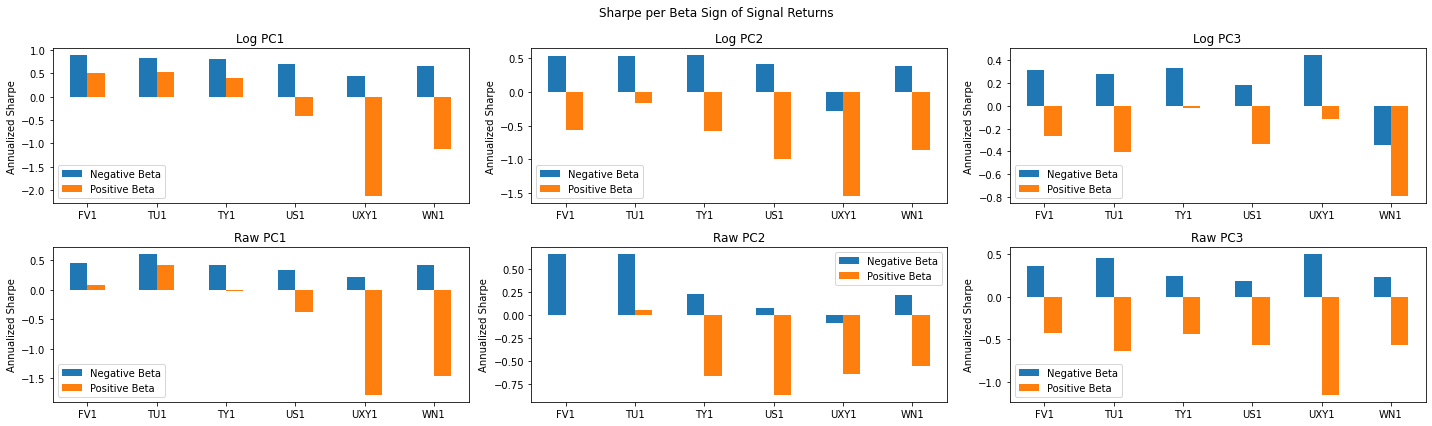

In [7]:
def plot_beta_sign_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 
    
    df_tmp = (df_sign_sharpe.assign(
        group_var = lambda x: x.input_val + " " + x.variable))

    group_vars = df_tmp.group_var.drop_duplicates().sort_values().to_list() 
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 3, figsize = (20,6))

    for group_var, ax in zip(group_vars, axes.flatten()): 

        (df_tmp.query(
            "group_var == @group_var").
            rename(columns = {"beta_pos": ""}).
            pivot(index = "security", columns = "", values = "sharpe").
            plot(
                ax     = ax,
                kind   = "bar",
                ylabel = "Annualized Sharpe",
                xlabel = "",
                rot    = 0,
                title  = group_var.split("_")[0].capitalize() + " " + group_var.split(" ")[-1]))

    fig.suptitle("Sharpe per Beta Sign of Signal Returns")
    plt.tight_layout()
    
plot_beta_sign_sharpe(df_sign_sharpe)